In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Mendefinisikan Path File sesuai direktori kamu
file_path = "/content/Dataset.csv"

# 2. Membaca dataset
print("Loading data...")
df = pd.read_csv(file_path)

# (Opsional) Pisahkan antara Fitur (X) dan Target/Label (y) jika kamu sudah siap
# Asumsikan kolom target kamu bernama 'time_to_erupt' (sesuaikan dengan nama aslinya)
# X = df.drop(columns=['time_to_erupt'])
# y = df['time_to_erupt']

# 3. SPLIT TAHAP 1: Pisahkan 70% untuk Train dan 30% sisanya untuk Val & Test
# Ingat: shuffle=False sangat penting untuk data time-series agar urutan waktu tidak rusak!
train_data, temp_data = train_test_split(df, test_size=0.30, shuffle=False)

# 4. SPLIT TAHAP 2: Membagi sisa 30% (temp_data) menjadi 15% Val dan 15% Test (dibagi 2 rata = 0.5)
val_data, test_data = train_test_split(temp_data, test_size=0.50, shuffle=False)

# 5. Cek hasil proporsi data
print("\n=== HASIL SPLIT DATA ===")
print(f"Total Dataset Utuh  : {len(df)} baris (100%)")
print(f"Data Latih (Train)  : {len(train_data)} baris (70%)")
print(f"Data Validasi (Val) : {len(val_data)} baris (15%)")
print(f"Data Uji (Test)     : {len(test_data)} baris (15%)")

# Sekarang train_data, val_data, dan test_data sudah siap untuk diproses ke tahap Normalisasi dan Windowing!

Loading data...

=== HASIL SPLIT DATA ===
Total Dataset Utuh  : 4431 baris (100%)
Data Latih (Train)  : 3101 baris (70%)
Data Validasi (Val) : 665 baris (15%)
Data Uji (Test)     : 665 baris (15%)


In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Asumsikan kolom target kamu bernama 'label' (Berdasarkan preview notebook kamu)
# Ubah jika namanya berbeda (misal: 'time_to_erupt')
target_col = 'label'

#print("\n--- MULAI DATA PREPARATION LANJUTAN ---")

# ==========================================
# 1. PEMISAHAN FITUR (X) DAN TARGET (y)
# ==========================================
X_train_raw = train_data.drop(columns=[target_col]).values
y_train_raw = train_data[target_col].values.reshape(-1, 1)

X_val_raw = val_data.drop(columns=[target_col]).values
y_val_raw = val_data[target_col].values.reshape(-1, 1)

X_test_raw = test_data.drop(columns=[target_col]).values
y_test_raw = test_data[target_col].values.reshape(-1, 1)

In [5]:
# ==========================================
# 2. NORMALISASI / SCALING DATA
# ==========================================
# Kita menggunakan 2 scaler terpisah untuk X (fitur) dan y (target)
# agar nanti mudah saat proses inverse_transform (mengembalikan nilai ke asli)
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# PENTING: Scaler HANYA di-fit (dipelajari) pada data TRAIN untuk mencegah Data Leakage
X_train_scaled = scaler_X.fit_transform(X_train_raw)
y_train_scaled = scaler_y.fit_transform(y_train_raw)

# Data Val dan Test hanya di-transform (mengikuti aturan dari data train)
X_val_scaled = scaler_X.transform(X_val_raw)
y_val_scaled = scaler_y.transform(y_val_raw)
X_test_scaled = scaler_X.transform(X_test_raw)
y_test_scaled = scaler_y.transform(y_test_raw)

In [8]:
# ==========================================
# 3. PEMBUATAN SEKUENS (WINDOWING) UNTUK LSTM/GRU
# ==========================================
# Lookback adalah berapa jumlah langkah waktu ke belakang yang dilihat model
# untuk memprediksi 1 titik di masa depan. (Kamu bisa ubah nilai ini saat eksperimen skripsi)
def create_multivariate_sequences(features, target, lookback=60):
    X, y = [], []

    # Looping dimulai dari index 'lookback' agar ada cukup data 60 baris ke belakang
    for i in range(lookback, len(features)):
        # Mengambil 60 baris ke belakang untuk SEMUA kolom fitur (X)
        X.append(features[i-lookback:i, :])
        # Mengambil 1 nilai target di baris saat ini (y)
        y.append(target[i])

    # Mengembalikan dalam bentuk array NumPy
    return np.array(X), np.array(y)

# ==========================================
# CONTOH CARA PAKAINYA DI DATA KAMU NANTI:
# ==========================================
lookback = 60

# Asumsi: `scaled_X_train` adalah data fitur (sensor) yang sudah dinormalisasi
# Asumsi: `train_labels` adalah data target (time_to_erupt)

# Terapkan fungsi ke data Train, Val, dan Test
X_train_3d, y_train_seq = create_multivariate_sequences(X_train_scaled, y_train_scaled, lookback)
X_val_3d, y_val_seq     = create_multivariate_sequences(X_val_scaled, y_val_scaled, lookback)
X_test_3d, y_test_seq   = create_multivariate_sequences(X_test_scaled, y_test_scaled, lookback)

# Cek dimensi outputnya (Otomatis sudah 3D tanpa perlu di-reshape manual lagi!)
print("Dimensi X_train 3D :", X_train_3d.shape) # Format: [samples, 60, jumlah_fitur_sensor]
print("Dimensi y_train    :", y_train_seq.shape)
# Cek dimensi/bentuk data (Shape) yang siap masuk ke Model
print("\n=== BENTUK DATA FINAL UNTUK MODEL LSTM/GRU ===")
print(f"X_train shape: {X_train_3d.shape} | y_train shape: {y_train_seq.shape}")
print(f"X_val shape  : {X_val_3d.shape} | y_val shape  : {y_val_seq.shape}")
print(f"X_test shape : {X_test_3d.shape} | y_test shape : {y_test_seq.shape}")

Dimensi X_train 3D : (3041, 60, 70)
Dimensi y_train    : (3041, 1)

=== BENTUK DATA FINAL UNTUK MODEL LSTM/GRU ===
X_train shape: (3041, 60, 70) | y_train shape: (3041, 1)
X_val shape  : (605, 60, 70) | y_val shape  : (605, 1)
X_test shape : (605, 60, 70) | y_test shape : (605, 1)


## MODEL

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Masking, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Asumsi input_shape didapat dari hasil sliding window
# input_shape = (lookback, jumlah_fitur), contoh: (60, 70)
num_timesteps = X_train_3d.shape[1]
num_features = X_train_3d.shape[2]
input_shape = (num_timesteps, num_features)

# ==========================================
# MODEL 1: LSTM (Long Short-Term Memory)
# ==========================================
def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Masking(mask_value=0.0), # Mengabaikan timestep yang di-padding dengan 0

        LSTM(64, return_sequences=True, activation='tanh'),
        Dropout(0.2), # Mencegah overfitting

        LSTM(32, activation='tanh'),
        Dropout(0.2),

        Dense(1, activation='linear') # Output layer regresi (1 node, linear)
    ], name="LSTM_Model")

    # Menggunakan MAE (Mean Absolute Error) karena lebih stabil untuk prediksi nilai besar seperti waktu
    model.compile(optimizer='adam', loss='mae', metrics=['mse'])
    return model

# ==========================================
# MODEL 2: GRU (Gated Recurrent Unit)
# ==========================================
def build_gru_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Masking(mask_value=0.0),

        GRU(64, return_sequences=True, activation='tanh'),
        Dropout(0.2),

        GRU(32, activation='tanh'),
        Dropout(0.2),

        Dense(1, activation='linear')
    ], name="GRU_Model")

    model.compile(optimizer='adam', loss='mae', metrics=['mse'])
    return model

# Inisialisasi kedua model
model_lstm = build_lstm_model(input_shape)
model_gru = build_gru_model(input_shape)

# Cek ringkasan arsitektur (bagus untuk dimasukkan ke bab 4 skripsi)
model_lstm.summary()
model_gru.summary()

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 60, 70)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 64)         │        34,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,009 (183.63 KB)

 Trainable params: 47,009 (183.63 KB)

 Non-trainable params: 0 (0.00 B)

Model: "GRU_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 60, 70)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 60, 64)         │        26,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,553 (138.88 KB)

 Trainable params: 35,553 (138.88 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Pengaturan Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',   # Memantau error di data validasi
    patience=10,          # Jika 10 epoch berturut-turut val_loss tidak turun, hentikan
    restore_best_weights=True # Kembalikan bobot ke model dengan val_loss terendah
)

EPOCHS = 100
BATCH_SIZE = 32


In [14]:
print("=== MEMULAI TRAINING MODEL LSTM ===")
history_lstm = model_lstm.fit(
    X_train_3d, y_train_seq,
    validation_data=(X_val_3d, y_val_seq), # Menggunakan data validasi dari split 15% tadi
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

=== MEMULAI TRAINING MODEL LSTM ===
Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - loss: 0.2767 - mse: 0.1158 - val_loss: 0.2545 - val_mse: 0.0917
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 0.2528 - mse: 0.0896 - val_loss: 0.2381 - val_mse: 0.0765
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - loss: 0.2462 - mse: 0.0830 - val_loss: 0.2399 - val_mse: 0.0782
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.2428 - mse: 0.0825 - val_loss: 0.2377 - val_mse: 0.0760
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - loss: 0.2404 - mse: 0.0800 - val_loss: 0.2413 - val_mse: 0.0794
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.2454 - mse: 0.0828 - val_loss: 0.2394 - val_mse: 0.0777
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.2383 - mse: 0.0777 - val_loss: 0.2399 - val_mse: 0.0782
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 0.2382 - mse: 0.0770 - val_loss: 0.2376 - val_mse: 0.0758
Epoch 9/100
96

In [12]:
print("\n=== MEMULAI TRAINING MODEL GRU ===")
history_gru = model_gru.fit(
    X_train_3d, y_train_seq,
    validation_data=(X_val_3d, y_val_seq), # Menggunakan data validasi yang sama agar fair
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)


=== MEMULAI TRAINING MODEL GRU ===
Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - loss: 0.3820 - mse: 0.2601 - val_loss: 0.2382 - val_mse: 0.0769
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.2559 - mse: 0.0934 - val_loss: 0.2401 - val_mse: 0.0780
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.2447 - mse: 0.0849 - val_loss: 0.2384 - val_mse: 0.0764
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.2491 - mse: 0.0857 - val_loss: 0.2379 - val_mse: 0.0763
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 0.2518 - mse: 0.0888 - val_loss: 0.2397 - val_mse: 0.0778
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 0.2467 - mse: 0.0857 - val_loss: 0.2394 - val_mse: 0.0777
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - loss: 0.2466 - mse: 0.0838 - val_loss: 0.2409 - val_mse: 0.0789
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.2476 - mse: 0.0849 - val_loss: 0.2400 - val_mse: 0.0775
Epoch 9/10

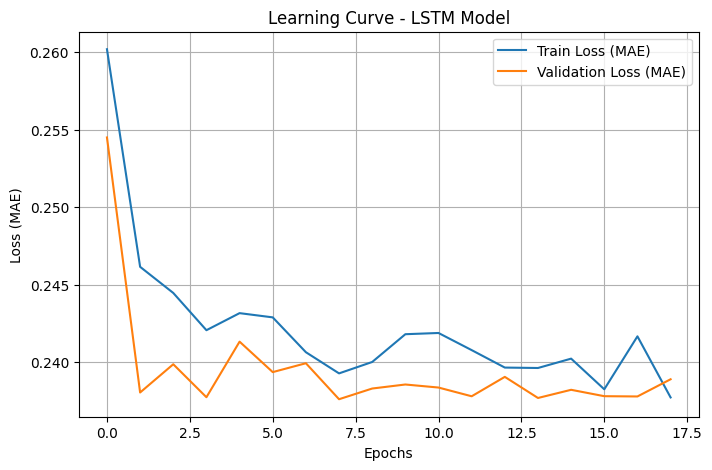

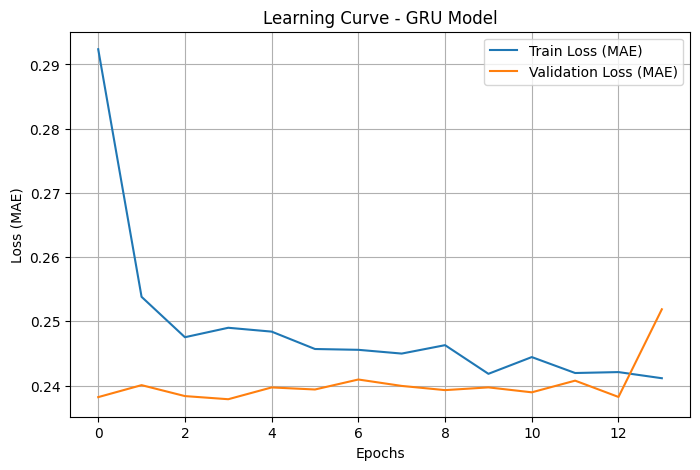

In [15]:
def plot_learning_curve(history, title):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss (MAE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MAE)')
    plt.title(f'Learning Curve - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MAE)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curve(history_lstm, "LSTM Model")
plot_learning_curve(history_gru, "GRU Model")

In [18]:
# # KODE 1
# # ==========================================
# # MODEL 3: HYBRID LSTM + GRU
# # ==========================================
# # Arsitektur: LSTM layer pertama untuk menangkap dependensi jangka panjang,
# # kemudian GRU layer kedua untuk efisiensi komputasi dan generalisasi.

# def build_hybrid_lstm_gru_model(input_shape):
#     model = Sequential([
#         Input(shape=input_shape),
#         Masking(mask_value=0.0),

#         # Layer 1: LSTM untuk menangkap long-term dependencies
#         LSTM(64, return_sequences=True, activation='tanh'),
#         Dropout(0.2),

#         # Layer 2: GRU untuk mengolah output LSTM secara lebih efisien
#         GRU(32, activation='tanh'),
#         Dropout(0.2),

#         Dense(1, activation='linear')  # Output regresi
#     ], name="Hybrid_LSTM_GRU_Model")

#     model.compile(optimizer='adam', loss='mae', metrics=['mse'])
#     return model

# # Inisialisasi model hybrid
# model_hybrid = build_hybrid_lstm_gru_model(input_shape)

# # Ringkasan arsitektur
# model_hybrid.summary()

In [ ]:
# # KODE 2
# # Mengambil dimensi input dari hasil sliding window
# num_time_steps = X_train_seq.shape[1] # sama dengan WINDOW_SIZE
# num_features = X_train_seq.shape[2]   # jumlah kolom sensor

# # Membangun Arsitektur Hybrid
# hybrid_model = Sequential([
#     Input(shape=(num_time_steps, num_features)),

#     # --- BLOK LSTM (Mengekstrak memori jangka panjang) ---
#     # return_sequences=True wajib agar outputnya tetap 3D dan bisa dioper ke layer RNN berikutnya (GRU)
#     LSTM(64, return_sequences=True, activation='tanh'),
#     Dropout(0.2), # Dropout untuk mencegah overfitting

#     # --- BLOK GRU (Mengekstrak memori jangka pendek & komputasi cepat) ---
#     # return_sequences=False karena ini layer RNN terakhir sebelum Dense layer
#     GRU(32, return_sequences=False, activation='tanh'),
#     Dropout(0.2),

#     # --- OUTPUT LAYER ---
#     # Output berupa 1 nilai regresi linear (time to erupt)
#     Dense(1, activation='linear')
# ])

# # Menggunakan optimizer Adam dan Loss MAE (cocok untuk dataset nilai letusan yang besar)
# hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#                      loss='mae',
#                      metrics=['mse'])

# hybrid_model.summary()

# # Menambahkan fungsi Early Stopping agar berhenti otomatis jika model sudah tidak berkembang
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Proses Training
# print("Memulai proses training model Hybrid...")
# history_hybrid = hybrid_model.fit(
#     X_train_seq, y_train_seq,
#     validation_data=(X_val_seq, y_val_seq),
#     epochs=50,             # Sesuaikan dengan kekuatan laptop Anda
#     batch_size=32,         # Jumlah sampel per update bobot
#     callbacks=[early_stop],
#     verbose=1
# )

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Masking, LSTM, GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Mendefinisikan Model dalam bentuk Fungsi (Seperti Kode 1)
def build_hybrid_lstm_gru(input_shape, learning_rate=0.001):
    model = Sequential([
        # Layer Input
        Input(shape=input_shape),

        # Layer Masking (Penting untuk mengabaikan padding nol)
        Masking(mask_value=0.0),

        # Layer 1: LSTM (Menangkap memori jangka panjang)
        # Harus True agar output berbentuk 3D (Sequence) dan bisa masuk ke RNN selanjutnya
        LSTM(64, return_sequences=True, activation='tanh', name="LSTM_Layer"),
        Dropout(0.2), # Mencegah overfitting

        # Layer 2: GRU (Proses komputasi lebih cepat untuk memori jangka pendek)
        # Harus False karena setelah ini masuk ke Dense Layer
        GRU(32, return_sequences=False, activation='tanh', name="GRU_Layer"),
        Dropout(0.2),

        # Output Layer: Regresi untuk memprediksi "time to erupt"
        Dense(1, activation='linear', name="Output_Layer")
    ], name="Hybrid_LSTM_GRU_Model")

    # Kompilasi Model dengan optimizer eksplisit (Seperti Kode 2)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mse'])

    return model

# 2. Mengambil Dimensi Input dari hasil Sliding Window Anda
# Asumsi Anda sudah membuat X_train_seq dari tahapan sliding window
num_time_steps = X_train_3d.shape[1]
num_features = X_train_3d.shape[2]
input_shape = (num_time_steps, num_features)

# 3. Inisialisasi Model
hybrid_model = build_hybrid_lstm_gru(input_shape, learning_rate=0.001)
hybrid_model.summary()

# 4. Setup Early Stopping & Training (Seperti Kode 2)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10, # Berhenti jika 10 epoch berturut-turut val_loss tidak membaik
    restore_best_weights=True
)

print("Memulai proses training model Hybrid LSTM+GRU...")
history_hybrid = hybrid_model.fit(
    X_train_3d, y_train_seq,
    validation_data=(X_val_3d, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Model: "Hybrid_LSTM_GRU_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_4 (Masking)             │ (None, 60, 70)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer (LSTM)               │ (None, 60, 64)         │        34,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_Layer (GRU)                 │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,001 (171.88 KB)

 Trainable params: 44,001 (171.88 KB)

 Non-trainable params: 0 (0.00 B)

Memulai proses training model Hybrid LSTM+GRU...
Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - loss: 0.3466 - mse: 0.1973 - val_loss: 0.2377 - val_mse: 0.0758
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - loss: 0.2466 - mse: 0.0848 - val_loss: 0.2412 - val_mse: 0.0793
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 0.2506 - mse: 0.0865 - val_loss: 0.2433 - val_mse: 0.0811
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - loss: 0.2505 - mse: 0.0874 - val_loss: 0.2422 - val_mse: 0.0802
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.2494 - mse: 0.0854 - val_loss: 0.2390 - val_mse: 0.0770
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 0.2403 - mse: 0.0810 - val_loss: 0.2402 - val_mse: 0.0781
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.2403 - mse: 0.0801 - val_loss: 0.2380 - val_mse: 0.0760
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.2402 - mse: 0.0791 - val_loss: 0.2379 - val_mse: 0.0761
Epoch 

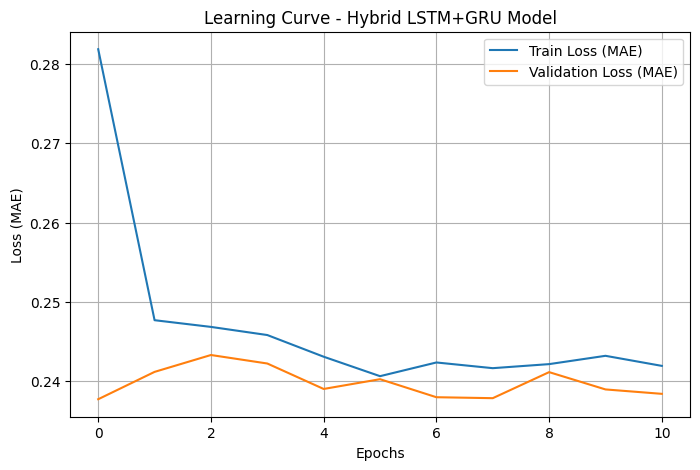

In [20]:
plot_learning_curve(history_hybrid, "Hybrid LSTM+GRU Model")

# SBi-LSTM-XGBoost (Stacked Bidirectional LSTM + XGBoost) dan SBi-GRU-XGBoost

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Masking, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# =====================================================================
# 1. MEMBANGUN MODEL HYBRID (SBi-LSTM dan SBi-GRU)
# =====================================================================

def build_sbi_rnn_extractor(input_shape, rnn_type='lstm'):
    model = Sequential(name=f"SBi_{rnn_type.upper()}_Feature_Extractor")
    model.add(Input(shape=input_shape))
    model.add(Masking(mask_value=0.0))

    # Layer 1: Bidirectional (Membaca arah maju dan mundur) - Return Sequence = True
    if rnn_type == 'lstm':
        model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh')))
    else:
        model.add(Bidirectional(GRU(64, return_sequences=True, activation='tanh')))
    model.add(Dropout(0.2))

    # Layer 2: Stacked Bidirectional - Return Sequence = False (karena menuju Dense)
    if rnn_type == 'lstm':
        model.add(Bidirectional(LSTM(32, activation='tanh')))
    else:
        model.add(Bidirectional(GRU(32, activation='tanh')))
    model.add(Dropout(0.2))

    # --- BAGIAN KRUSIAL UNTUK XGBOOST ---
    # Kita membuat Dense layer bernama 'feature_layer'.
    # Output dari layer ini akan berukuran (32) dimensi yang menyimpan RANGKUMAN temporal 60 hari ke belakang
    model.add(Dense(32, activation='relu', name='feature_layer'))

    # Layer Output (untuk memancing model agar bisa di-train dengan backpropagation)
    model.add(Dense(1, activation='linear', name='output_layer'))

    model.compile(optimizer='adam', loss='mae')
    return model

# Asumsi X_train_3d, y_train_seq sudah didefinisikan dari kodingan sliding window sebelumnya
input_shape = (X_train_3d.shape[1], X_train_3d.shape[2])

# Buat model
model_sbi_lstm = build_sbi_rnn_extractor(input_shape, rnn_type='lstm')
model_sbi_gru = build_sbi_rnn_extractor(input_shape, rnn_type='gru')

model_sbi_lstm.summary()



Model: "SBi_LSTM_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_5 (Masking)             │ (None, 60, 70)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 60, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_layer (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,449 (439.25 KB)

 Trainable params: 112,449 (439.25 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# =====================================================================
# 2. TRAINING MODEL DEEP LEARNING (Hanya untuk mengajari Feature Extractor)
# =====================================================================

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\n--- Training SBi-LSTM (Tahap 1: Ekstraksi Fitur) ---")
model_sbi_lstm.fit(X_train_3d, y_train_seq,
                   validation_data=(X_val_3d, y_val_seq),
                   epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)

print("\n--- Training SBi-GRU (Tahap 1: Ekstraksi Fitur) ---")
model_sbi_gru.fit(X_train_3d, y_train_seq,
                  validation_data=(X_val_3d, y_val_seq),
                  epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)




--- Training SBi-LSTM (Tahap 1: Ekstraksi Fitur) ---
Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 27s 180ms/step - loss: 0.2927 - val_loss: 0.2387
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step - loss: 0.2476 - val_loss: 0.2375
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - loss: 0.2433 - val_loss: 0.2402
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 175ms/step - loss: 0.2397 - val_loss: 0.2384
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 177ms/step - loss: 0.2419 - val_loss: 0.2394
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step - loss: 0.2448 - val_loss: 0.2394
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - loss: 0.2404 - val_loss: 0.2391
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - loss: 0.2453 - val_loss: 0.2417
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - loss: 0.2443 - val_loss: 0.2381
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - loss: 0.2385 - val_loss: 0.2382
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - loss: 0.2441 - val_

In [24]:
# =====================================================================
# 3. PROSES HYBRID: MEMOTONG MODEL DL & MENGEKSTRAK FITUR
# =====================================================================
# Kita mendefinisikan ulang model agar outputnya berhenti di 'feature_layer'
# Menggunakan model.input langsung biasanya berhasil jika model sudah di-fit
extractor_lstm = Model(inputs=model_sbi_lstm.inputs,
                       outputs=model_sbi_lstm.get_layer('feature_layer').output)

extractor_gru = Model(inputs=model_sbi_gru.inputs,
                      outputs=model_sbi_gru.get_layer('feature_layer').output)

# Merubah data 3D menjadi Fitur 2D yang padat makna (Dense Features)
print("\nMengekstrak Fitur Temporal untuk dimasukkan ke XGBoost...")
features_train_lstm = extractor_lstm.predict(X_train_3d)
features_test_lstm  = extractor_lstm.predict(X_test_3d)

features_train_gru = extractor_gru.predict(X_train_3d)
features_test_gru  = extractor_gru.predict(X_test_3d)

# Cek dimensinya (Harusnya menjadi 2D: (Jumlah_Sample, 32))
print("Bentuk fitur SBi-LSTM train:", features_train_lstm.shape)
print("Bentuk fitur SBi-GRU train:", features_train_gru.shape)


Mengekstrak Fitur Temporal untuk dimasukkan ke XGBoost...
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Bentuk fitur SBi-LSTM train: (3041, 32)
Bentuk fitur SBi-GRU train: (3041, 32)


In [29]:
# =====================================================================
# 4. TRAINING XGBOOST SEBAGAI FINAL REGRESSOR (TAHAP 2)
# =====================================================================

# Inisialisasi XGBoost Regressor (parameter bisa dituning nanti)
xgb_lstm = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
xgb_gru  = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)

print("\n--- Training XGBoost pada Fitur SBi-LSTM ---")
xgb_lstm.fit(features_train_lstm, y_train_seq)

# print("\n--- Training XGBoost pada Fitur SBi-GRU ---")
# xgb_gru.fit(features_train_gru, y_train_seq)




--- Training XGBoost pada Fitur SBi-LSTM ---


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [30]:
print("\n--- Training XGBoost pada Fitur SBi-GRU ---")
xgb_gru.fit(features_train_gru, y_train_seq)


--- Training XGBoost pada Fitur SBi-GRU ---


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)


=== HASIL EVALUASI MODEL HYBRID (MAE) ===
SBi-LSTM-XGBoost MAE : 0.2415
SBi-GRU-XGBoost MAE  : 0.2347


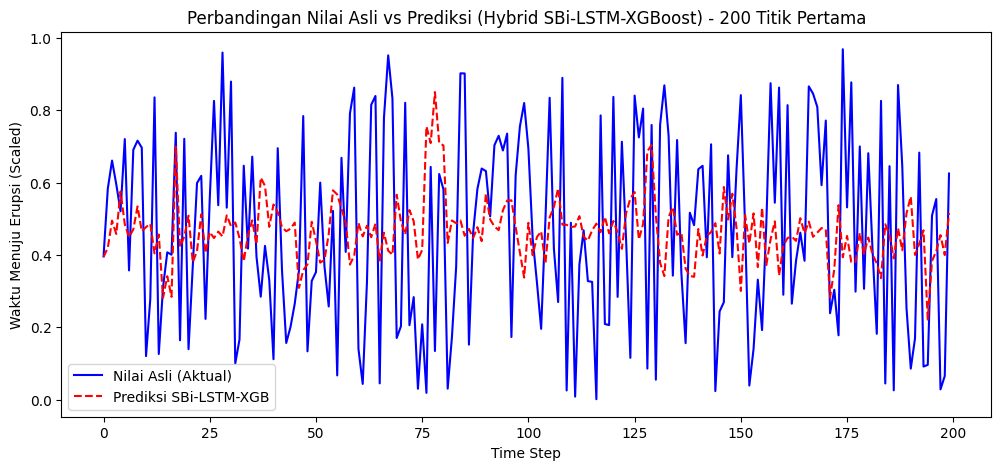

In [31]:
# =====================================================================
# 5. PREDIKSI DAN EVALUASI HYBRID MODEL
# =====================================================================

# Lakukan Prediksi di data Test
y_pred_lstm_xgb = xgb_lstm.predict(features_test_lstm)
y_pred_gru_xgb  = xgb_gru.predict(features_test_gru)

# Evaluasi MAE (Mean Absolute Error)
mae_lstm_xgb = mean_absolute_error(y_test_seq, y_pred_lstm_xgb)
mae_gru_xgb = mean_absolute_error(y_test_seq, y_pred_gru_xgb)

print("\n=== HASIL EVALUASI MODEL HYBRID (MAE) ===")
print(f"SBi-LSTM-XGBoost MAE : {mae_lstm_xgb:.4f}")
print(f"SBi-GRU-XGBoost MAE  : {mae_gru_xgb:.4f}")

# (Opsional) Plot Hasil Prediksi untuk SBi-LSTM-XGBoost
plt.figure(figsize=(12, 5))
plt.plot(y_test_seq[:200], label='Nilai Asli (Aktual)', color='blue')
plt.plot(y_pred_lstm_xgb[:200], label='Prediksi SBi-LSTM-XGB', color='red', linestyle='dashed')
plt.title('Perbandingan Nilai Asli vs Prediksi (Hybrid SBi-LSTM-XGBoost) - 200 Titik Pertama')
plt.xlabel('Time Step')
plt.ylabel('Waktu Menuju Erupsi (Scaled)')
plt.legend()
plt.show()

#Analisis Komprehensif Semua Model

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# =====================================================================
# EVALUASI LENGKAP SEMUA 5 MODEL PADA DATA TEST
# =====================================================================

def evaluate_full(model_name, y_actual, y_predicted, scaler_y):
    """Evaluasi model dengan inverse_transform ke skala asli."""
    # Inverse transform ke skala asli
    y_actual_inv = scaler_y.inverse_transform(y_actual.reshape(-1, 1)).flatten()
    y_pred_inv   = scaler_y.inverse_transform(y_predicted.reshape(-1, 1)).flatten()

    mae  = mean_absolute_error(y_actual_inv, y_pred_inv)
    mse  = mean_squared_error(y_actual_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_actual_inv, y_pred_inv) * 100
    r2   = r2_score(y_actual_inv, y_pred_inv)

    return {
        'Model': model_name,
        'MAE': round(mae, 4),
        'MSE': round(mse, 4),
        'RMSE': round(rmse, 4),
        'MAPE (%)': round(mape, 2),
        'R²': round(r2, 4),
        'y_actual': y_actual_inv,
        'y_pred': y_pred_inv
    }

# --- Prediksi dari 3 model Deep Learning murni ---
y_pred_lstm   = model_lstm.predict(X_test_3d, verbose=0).flatten()
y_pred_gru    = model_gru.predict(X_test_3d, verbose=0).flatten()
y_pred_hybrid = hybrid_model.predict(X_test_3d, verbose=0).flatten()

# y_pred_lstm_xgb dan y_pred_gru_xgb sudah didefinisikan di cell sebelumnya

y_actual = y_test_seq.flatten()

# --- Evaluasi semua model ---
results = []
results.append(evaluate_full("LSTM",              y_actual, y_pred_lstm,     scaler_y))
results.append(evaluate_full("GRU",               y_actual, y_pred_gru,      scaler_y))
results.append(evaluate_full("Hybrid LSTM+GRU",   y_actual, y_pred_hybrid,   scaler_y))
results.append(evaluate_full("SBi-LSTM-XGBoost",  y_actual, y_pred_lstm_xgb, scaler_y))
results.append(evaluate_full("SBi-GRU-XGBoost",   y_actual, y_pred_gru_xgb,  scaler_y))

# --- Tabel Perbandingan ---
comparison_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['y_actual', 'y_pred']} for r in results])
comparison_df = comparison_df.set_index('Model')

print("=" * 75)
print("  TABEL PERBANDINGAN PERFORMA SEMUA MODEL (SKALA ASLI)")
print("=" * 75)
print(comparison_df.to_string())

# Highlight model terbaik
best_rmse = comparison_df['RMSE'].idxmin()
best_r2   = comparison_df['R²'].idxmax()
print(f"\n>>> Model Terbaik (RMSE terendah)  : {best_rmse} ({comparison_df.loc[best_rmse, 'RMSE']:.4f})")
print(f">>> Model Terbaik (R² tertinggi)   : {best_r2} ({comparison_df.loc[best_r2, 'R²']:.4f})")

comparison_df

  TABEL PERBANDINGAN PERFORMA SEMUA MODEL (SKALA ASLI)
                           MAE           MSE          RMSE  MAPE (%)      R²
Model                                                                       
LSTM              1.136956e+07  1.756829e+14  1.325454e+07    331.11  0.0005
GRU               1.135570e+07  1.755422e+14  1.324923e+07    325.28  0.0013
Hybrid LSTM+GRU   1.140111e+07  1.761751e+14  1.327310e+07    343.20 -0.0023
SBi-LSTM-XGBoost  1.184221e+07  1.971008e+14  1.403926e+07    326.89 -0.1214
SBi-GRU-XGBoost   1.150987e+07  1.857374e+14  1.362855e+07    347.47 -0.0567

>>> Model Terbaik (RMSE terendah)  : GRU (13249234.2680)
>>> Model Terbaik (R² tertinggi)   : GRU (0.0013)


,MAE,MSE,RMSE,MAPE (%),R²
Model,,,,,
LSTM,1.136956e+07,1.756829e+14,1.325454e+07,331.11,0.0005
GRU,1.135570e+07,1.755422e+14,1.324923e+07,325.28,0.0013
Hybrid LSTM+GRU,1.140111e+07,1.761751e+14,1.327310e+07,343.20,-0.0023
SBi-LSTM-XGBoost,1.184221e+07,1.971008e+14,1.403926e+07,326.89,-0.1214
SBi-GRU-XGBoost,1.150987e+07,1.857374e+14,1.362855e+07,347.47,-0.0567


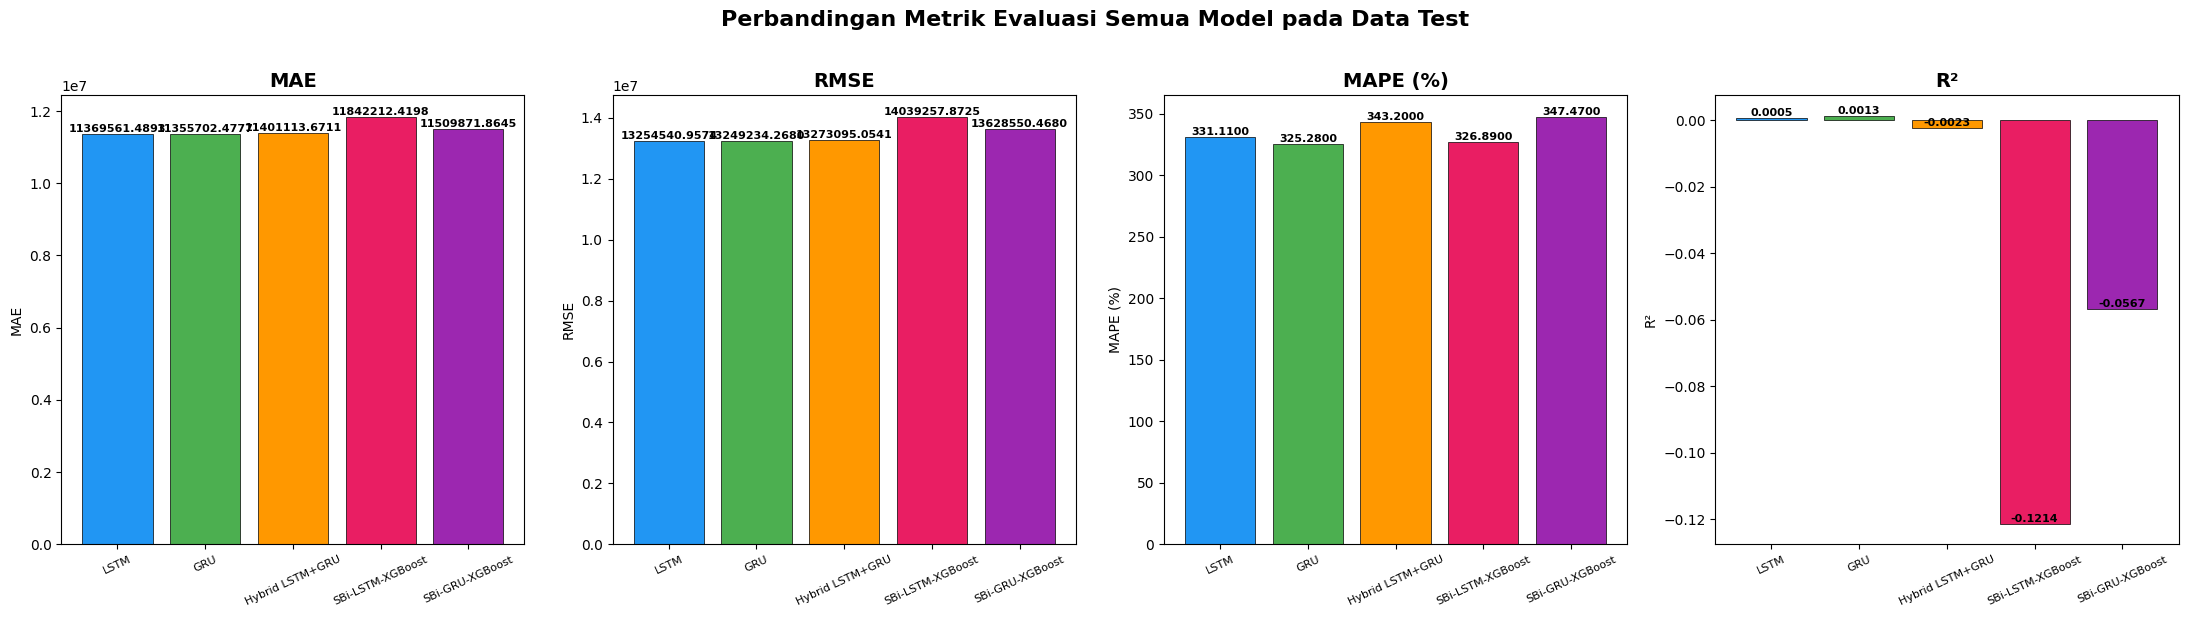

In [33]:
# =====================================================================
# VISUALISASI 1: BAR CHART PERBANDINGAN METRIK
# =====================================================================
fig, axes = plt.subplots(1, 4, figsize=(22, 6))
metrics = ['MAE', 'RMSE', 'MAPE (%)', 'R²']
colors = ['#2196F3', '#4CAF50', '#FF9800', '#E91E63', '#9C27B0']
model_names = comparison_df.index.tolist()

for i, metric in enumerate(metrics):
    values = comparison_df[metric].values
    bars = axes[i].bar(model_names, values, color=colors, edgecolor='black', linewidth=0.5)
    axes[i].set_title(metric, fontsize=14, fontweight='bold')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=25, labelsize=8)
    for bar, val in zip(bars, values):
        axes[i].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                     f'{val:.4f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.suptitle('Perbandingan Metrik Evaluasi Semua Model pada Data Test', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

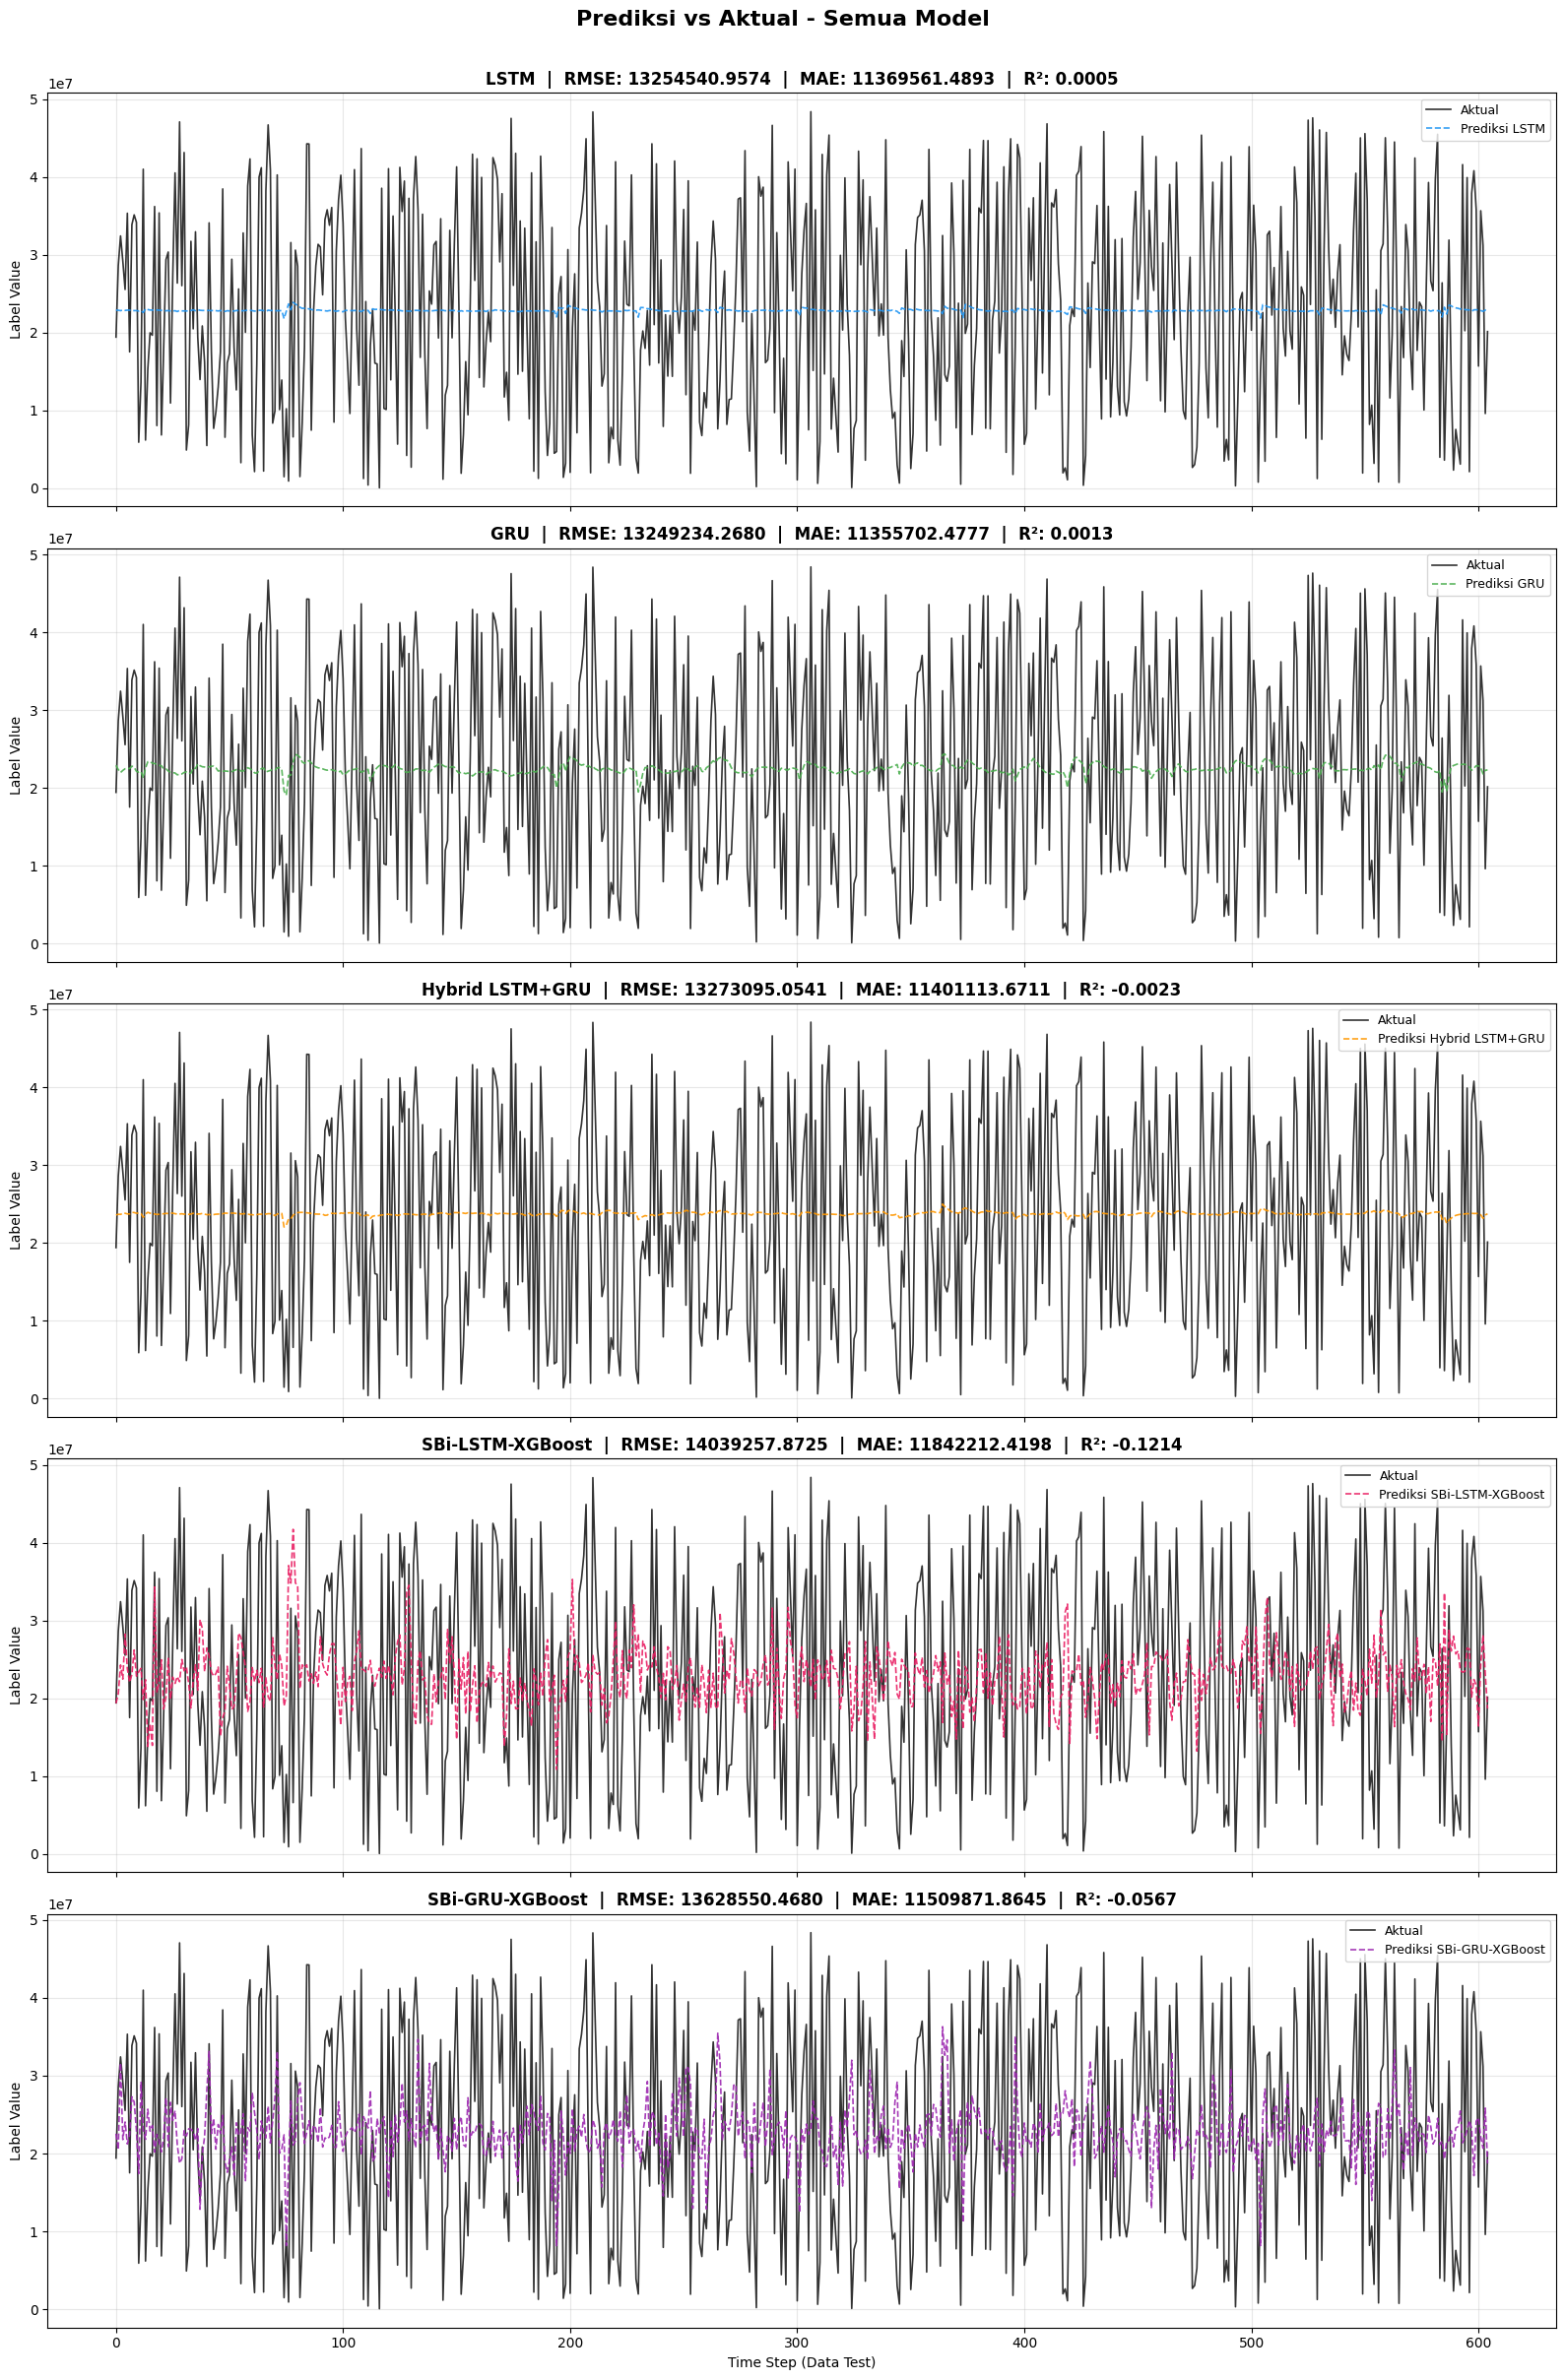

In [34]:
# =====================================================================
# VISUALISASI 2: PREDIKSI VS AKTUAL UNTUK SETIAP MODEL (SUBPLOT)
# =====================================================================
fig, axes = plt.subplots(5, 1, figsize=(16, 24), sharex=True)

model_results = [
    (results[0], '#2196F3'),   # LSTM
    (results[1], '#4CAF50'),   # GRU
    (results[2], '#FF9800'),   # Hybrid LSTM+GRU
    (results[3], '#E91E63'),   # SBi-LSTM-XGBoost
    (results[4], '#9C27B0'),   # SBi-GRU-XGBoost
]

for ax, (result, color) in zip(axes, model_results):
    name = result['Model']
    ax.plot(result['y_actual'], label='Aktual', color='black', linewidth=1.2, alpha=0.8)
    ax.plot(result['y_pred'], label=f'Prediksi {name}', color=color, linewidth=1.2, linestyle='--', alpha=0.9)
    ax.set_title(f'{name}  |  RMSE: {result["RMSE"]:.4f}  |  MAE: {result["MAE"]:.4f}  |  R²: {result["R²"]:.4f}',
                 fontsize=12, fontweight='bold')
    ax.set_ylabel('Label Value')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time Step (Data Test)')
plt.suptitle('Prediksi vs Aktual - Semua Model', fontsize=16, fontweight='bold', y=1.005)
plt.tight_layout()
plt.show()

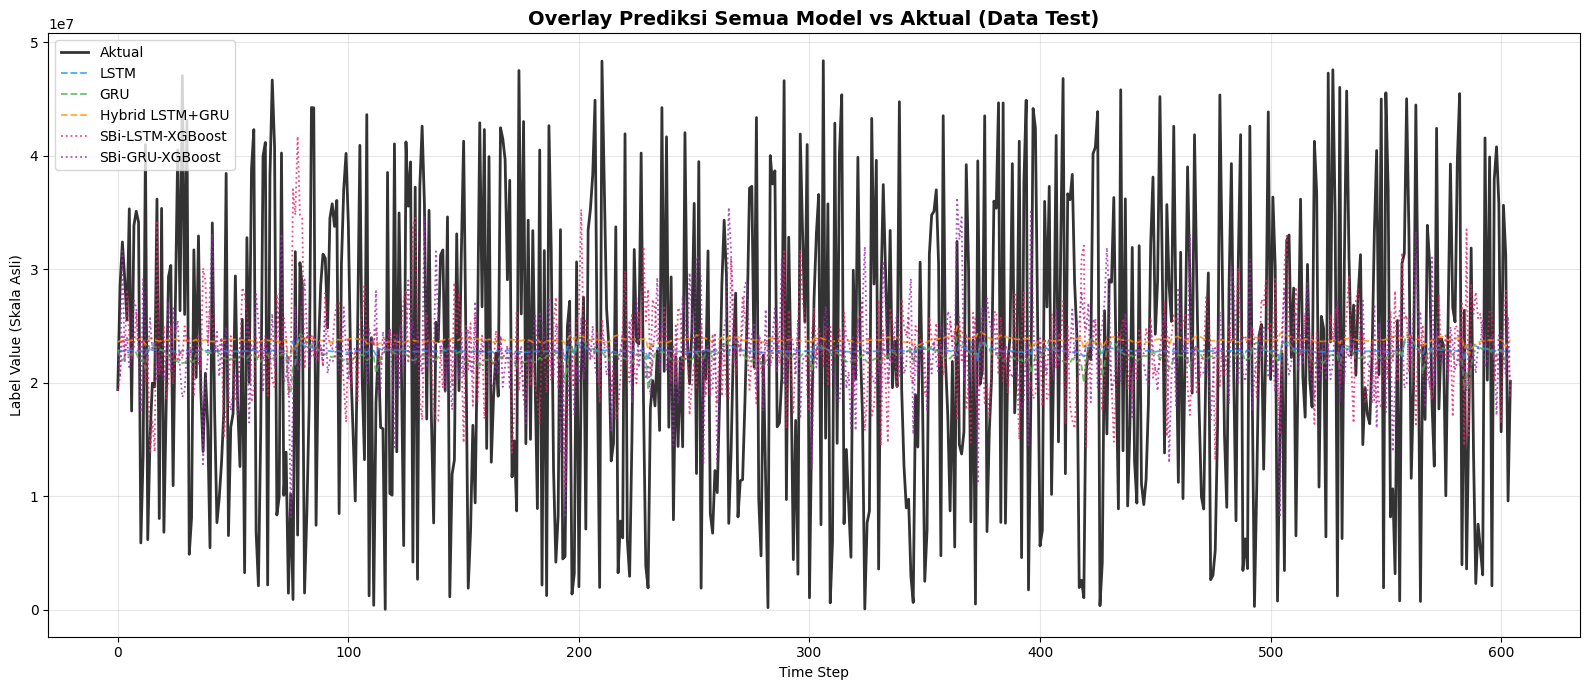

In [35]:
# =====================================================================
# VISUALISASI 3: OVERLAY SEMUA PREDIKSI DALAM SATU GRAFIK
# =====================================================================
plt.figure(figsize=(16, 7))
plt.plot(results[0]['y_actual'], label='Aktual', color='black', linewidth=2, alpha=0.8)
plt.plot(results[0]['y_pred'], label='LSTM', color='#2196F3', linewidth=1.3, linestyle='--', alpha=0.8)
plt.plot(results[1]['y_pred'], label='GRU', color='#4CAF50', linewidth=1.3, linestyle='--', alpha=0.8)
plt.plot(results[2]['y_pred'], label='Hybrid LSTM+GRU', color='#FF9800', linewidth=1.3, linestyle='--', alpha=0.8)
plt.plot(results[3]['y_pred'], label='SBi-LSTM-XGBoost', color='#E91E63', linewidth=1.3, linestyle=':', alpha=0.8)
plt.plot(results[4]['y_pred'], label='SBi-GRU-XGBoost', color='#9C27B0', linewidth=1.3, linestyle=':', alpha=0.8)

plt.title('Overlay Prediksi Semua Model vs Aktual (Data Test)', fontsize=14, fontweight='bold')
plt.xlabel('Time Step')
plt.ylabel('Label Value (Skala Asli)')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

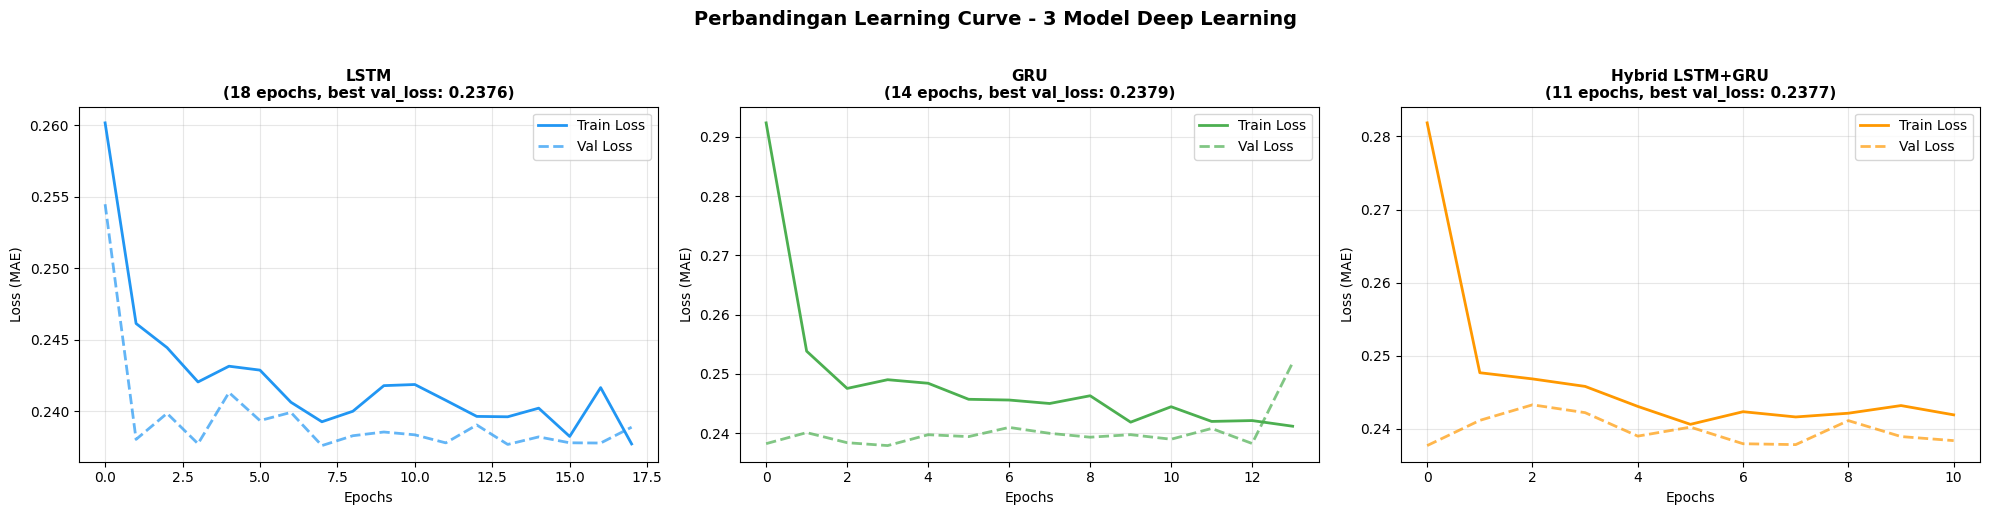

In [36]:
# =====================================================================
# VISUALISASI 4: LEARNING CURVE PERBANDINGAN 3 MODEL DL
# =====================================================================
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

histories = [
    (history_lstm,   "LSTM",            '#2196F3'),
    (history_gru,    "GRU",             '#4CAF50'),
    (history_hybrid, "Hybrid LSTM+GRU", '#FF9800'),
]

for ax, (hist, name, color) in zip(axes, histories):
    epochs_ran = len(hist.history['loss'])
    ax.plot(hist.history['loss'], label='Train Loss', color=color, linewidth=2)
    ax.plot(hist.history['val_loss'], label='Val Loss', color=color, linewidth=2, linestyle='--', alpha=0.7)
    ax.set_title(f'{name}\n({epochs_ran} epochs, best val_loss: {min(hist.history["val_loss"]):.4f})',
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss (MAE)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Perbandingan Learning Curve - 3 Model Deep Learning', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

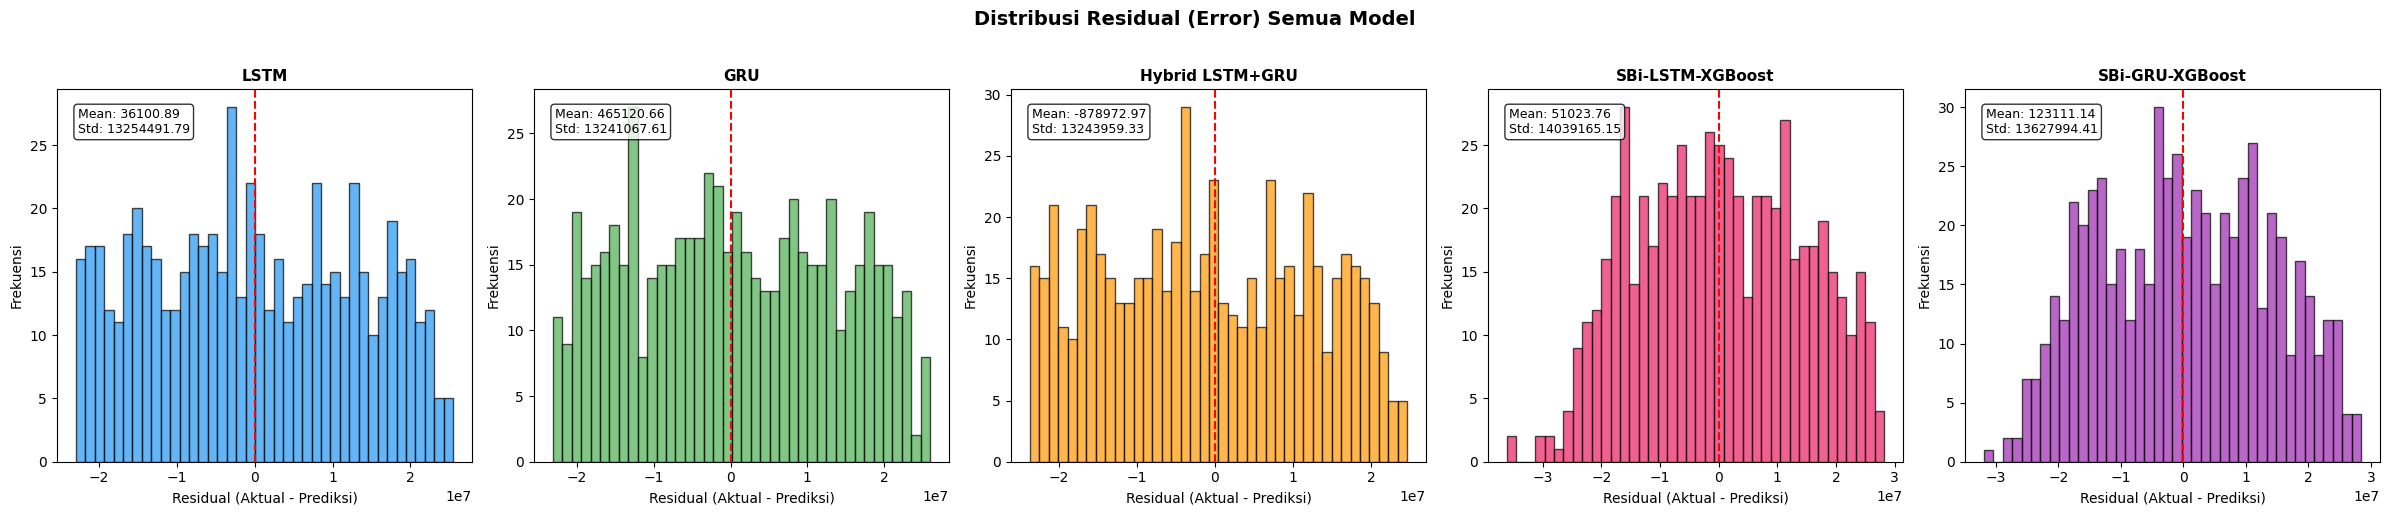

In [37]:
# =====================================================================
# VISUALISASI 5: DISTRIBUSI ERROR (RESIDUAL) SETIAP MODEL
# =====================================================================
fig, axes = plt.subplots(1, 5, figsize=(24, 5))
colors = ['#2196F3', '#4CAF50', '#FF9800', '#E91E63', '#9C27B0']

for ax, result, color in zip(axes, results, colors):
    residual = result['y_actual'] - result['y_pred']
    ax.hist(residual, bins=40, color=color, edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
    ax.set_title(f'{result["Model"]}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Residual (Aktual - Prediksi)')
    ax.set_ylabel('Frekuensi')
    mean_res = np.mean(residual)
    std_res  = np.std(residual)
    ax.text(0.05, 0.95, f'Mean: {mean_res:.2f}\nStd: {std_res:.2f}',
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Distribusi Residual (Error) Semua Model', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()